In [6]:
# Install required packages
!pip install einops

# Core libraries
import os
import numpy as np
from PIL import Image
from einops import rearrange
# PyTorch and torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import einsum
# Utility for progress bars
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt

# Custom dataset for mask images (single-channel or RGB)
class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, fname), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Update these paths to your dataset location
base_dir = '/kaggle/input/train-1/predicted_over22'
train_dir = os.path.join(base_dir, 'Train2')
val_dir = os.path.join(base_dir, 'Val2')
test_dir = os.path.join(base_dir, 'Test2')

img_size = 224
batch_size = 16

# Define image transformations (resize, tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Instantiate datasets
train_dataset = MaskDataset(train_dir, transform=transform)
val_dataset = MaskDataset(val_dir, transform=transform)
test_dataset = MaskDataset(test_dir, transform=transform)

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print class mapping and distribution
num_classes = len(train_dataset.class_to_idx)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_dataset.class_to_idx)

# Optional: Check class distribution
class_counts = {}
for _, label in train_dataset.samples:
    class_counts[label] = class_counts.get(label, 0) + 1
print("Class distribution:", class_counts)

class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

# In LayerNorm, we normalize each token by itself.
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        # return self.fn(self.norm(x), **kwargs)     # PreNorm for version 1
        return self.norm(self.fn(x, **kwargs))      # PostNorm for version 2

class FeedForward(nn.Module):
    # mlp_dim = hidden_dim * 4 where dim=hidden_dim=(96,192,384,768)->channels
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

def create_mask(window_size, displacement, upper_lower, left_right):
    # To handle cycle patches
    mask = torch.zeros(window_size ** 2, window_size ** 2)  # (49,49) for window_size=7

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')  # down left section
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')  # up right section

    if left_right:  # to handle last vertical patches
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

# window_size is 7
class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads
        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted
        
        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)

            # masks are NOT learnable parameters; requires_grad=False
            self.upper_lower_mask = nn.Parameter(
                create_mask(window_size=window_size, displacement=displacement, 
                          upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(
                create_mask(window_size=window_size, displacement=displacement, 
                          upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)

        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d', 
                              h=self.heads, w_h=self.window_size, w_w=self.window_size), qkv)

        # Dot Product Similarity
        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)
        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)', 
                       h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)

        return out

class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(
            dim=dim, heads=heads, head_dim=head_dim, shifted=shifted,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x

class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor,
                 num_heads, head_dim, window_size, relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(
            in_channels=in_channels, out_channels=hidden_dimension, 
            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, 
                         mlp_dim=hidden_dimension * 4, shifted=False, window_size=window_size, 
                         relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, 
                         mlp_dim=hidden_dimension * 4, shifted=True, window_size=window_size, 
                         relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)

class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, 
                 head_dim=32, window_size=7, downscaling_factors=(4, 2, 2, 2), 
                 relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(
            in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
            downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
        self.stage2 = StageModule(
            in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
            downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
        self.stage3 = StageModule(
            in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
            downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
        self.stage4 = StageModule(
            in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
            downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
            window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)

# Example model instantiation
# Adjust parameters based on your dataset
model = SwinTransformer(
    hidden_dim=96,
    layers=[2, 2, 6, 2],
    heads=[3, 6, 12, 24],
    channels=3,
    num_classes=num_classes,  # This will be determined by your dataset
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)

print(f"Model created with {num_classes} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Number of classes: 2
Class mapping: {'Non Tumor': 0, 'Tumor': 1}
Class distribution: {0: 540, 1: 480}
Model created with 2 classes
Total parameters: 27,510,938


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = swin_t(
    hidden_dim=96,
    layers=(2,2,6,2),
    heads=(3,6,12,24),
    channels=3,
    num_classes=num_classes,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4,2,2,2),
    relative_pos_embedding=True
)
model = model.to(device)

# Print model summary
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {train_dataset.class_to_idx}")

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
num_epochs = 15
best_val_acc = 0.0
best_val_f1 = 0.0
checkpoint_interval = 3

# Enhanced history tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

def evaluate_model(model, data_loader, device, criterion):
    """Comprehensive model evaluation with all metrics"""
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    
    # Calculate precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, conf_matrix, all_labels, all_preds

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plot confusion matrix with proper formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Get class names for confusion matrix
class_names = list(train_dataset.class_to_idx.keys())

# Training loop with enhanced evaluation
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train

    # Validation phase with comprehensive evaluation
    val_loss, val_acc, val_precision, val_recall, val_f1, val_conf_matrix, _, _ = evaluate_model(
        model, val_loader, device, criterion
    )

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    scheduler.step(val_loss)

    # Enhanced epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"  Val   - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    print("-" * 70)

    # Save best model based on F1 score (more robust than accuracy for imbalanced datasets)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'train_loss': train_loss,
            'history': history,
            'confusion_matrix': val_conf_matrix
        }, "best_swin_predicted_mask.pth")
        print(f"🎯 New best model saved! F1: {val_f1:.4f}, Acc: {val_acc:.2f}%")

    # Save checkpoint every 3 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'history': history,
            'confusion_matrix': val_conf_matrix
        }, checkpoint_path)
        print(f"💾 Checkpoint saved: {checkpoint_path}")

print(f"\n🎉 Training complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best validation F1 score: {best_val_f1:.4f}")


Model initialized with 27,510,938 parameters
Number of classes: 2
Class mapping: {'Non Tumor': 0, 'Tumor': 1}


Epoch 1/15 [Train]: 100%|██████████| 64/64 [00:10<00:00,  5.91it/s]


Epoch 1/15
  Train - Loss: 0.8599, Acc: 50.20%
  Val   - Loss: 0.6578, Acc: 63.22%
  Val   - Precision: 0.3997, Recall: 0.6322, F1: 0.4897
----------------------------------------------------------------------
🎯 New best model saved! F1: 0.4897, Acc: 63.22%


Epoch 2/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.74it/s]


Epoch 2/15
  Train - Loss: 0.7248, Acc: 50.78%
  Val   - Loss: 0.6499, Acc: 63.22%
  Val   - Precision: 0.3997, Recall: 0.6322, F1: 0.4897
----------------------------------------------------------------------


Epoch 3/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.75it/s]


Epoch 3/15
  Train - Loss: 0.4370, Acc: 77.16%
  Val   - Loss: 0.1484, Acc: 96.26%
  Val   - Precision: 0.9647, Recall: 0.9626, F1: 0.9622
----------------------------------------------------------------------
🎯 New best model saved! F1: 0.9622, Acc: 96.26%
💾 Checkpoint saved: checkpoint_epoch_3.pth


Epoch 4/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.77it/s]


Epoch 4/15
  Train - Loss: 0.2237, Acc: 94.51%
  Val   - Loss: 0.1767, Acc: 95.11%
  Val   - Precision: 0.9547, Recall: 0.9511, F1: 0.9503
----------------------------------------------------------------------


Epoch 5/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.77it/s]


Epoch 5/15
  Train - Loss: 0.1733, Acc: 95.00%
  Val   - Loss: 0.1781, Acc: 95.98%
  Val   - Precision: 0.9622, Recall: 0.9598, F1: 0.9592
----------------------------------------------------------------------


Epoch 6/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


Epoch 6/15
  Train - Loss: 0.1655, Acc: 95.69%
  Val   - Loss: 0.1180, Acc: 97.13%
  Val   - Precision: 0.9725, Recall: 0.9713, F1: 0.9710
----------------------------------------------------------------------
🎯 New best model saved! F1: 0.9710, Acc: 97.13%
💾 Checkpoint saved: checkpoint_epoch_6.pth


Epoch 7/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


Epoch 7/15
  Train - Loss: 0.1077, Acc: 97.65%
  Val   - Loss: 0.0717, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------
🎯 New best model saved! F1: 0.9856, Acc: 98.56%


Epoch 8/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


Epoch 8/15
  Train - Loss: 0.0855, Acc: 98.14%
  Val   - Loss: 0.0694, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------


Epoch 9/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.73it/s]


Epoch 9/15
  Train - Loss: 0.0847, Acc: 98.14%
  Val   - Loss: 0.0697, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------
💾 Checkpoint saved: checkpoint_epoch_9.pth


Epoch 10/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


Epoch 10/15
  Train - Loss: 0.0846, Acc: 98.14%
  Val   - Loss: 0.0687, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------


Epoch 11/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


Epoch 11/15
  Train - Loss: 0.0838, Acc: 98.14%
  Val   - Loss: 0.0748, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------


Epoch 12/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


Epoch 12/15
  Train - Loss: 0.0892, Acc: 98.14%
  Val   - Loss: 0.0716, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------
💾 Checkpoint saved: checkpoint_epoch_12.pth


Epoch 13/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.80it/s]


Epoch 13/15
  Train - Loss: 0.0814, Acc: 98.14%
  Val   - Loss: 0.0690, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------


Epoch 14/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.75it/s]


Epoch 14/15
  Train - Loss: 0.0799, Acc: 98.24%
  Val   - Loss: 0.0717, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------


Epoch 15/15 [Train]: 100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


Epoch 15/15
  Train - Loss: 0.0798, Acc: 98.14%
  Val   - Loss: 0.0682, Acc: 98.56%
  Val   - Precision: 0.9860, Recall: 0.9856, F1: 0.9856
----------------------------------------------------------------------
💾 Checkpoint saved: checkpoint_epoch_15.pth

🎉 Training complete!
Best validation accuracy: 98.56%
Best validation F1 score: 0.9856


In [8]:
# ===================================================================
# 🧪 COMPREHENSIVE SWIN TRANSFORMER CROSS-DATASET TESTING
# ===================================================================

import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import cv2
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, cohen_kappa_score,
    balanced_accuracy_score, accuracy_score, precision_recall_curve,
    average_precision_score, roc_auc_score, fbeta_score
)
from tqdm import tqdm
import json
import pandas as pd
from collections import defaultdict
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_theme()

# ===================================================================
# 🔧 TESTING CONFIGURATION
# ===================================================================

# UPDATE THESE PATHS FOR YOUR TESTING
TEST_FOLDER_PATH = "/kaggle/input/test-final"  # Your test folder with tumor/no tumor subfolders
REFERENCE_DATASET_PATH = "/kaggle/input/your-training-dataset/Train2"  # For color normalization
MODEL_CHECKPOINT_PATH = "best_swin_model.pth"  # Your saved model checkpoint (optional)

# Model parameters (should match training)
IMG_SIZE = 224
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🎯 **SWIN TRANSFORMER COMPREHENSIVE TESTING FRAMEWORK**")
print(f"📱 Device: {DEVICE}")
print(f"📂 Test folder: {TEST_FOLDER_PATH}")
print("=" * 70)

# ===================================================================
# 🎨 ENHANCED COLOR INTENSITY ANALYZER FOR SWIN TRANSFORMER
# ===================================================================

class SwinTransformerColorNormalizer:
    """Specialized color normalizer for Swin Transformer overlay images"""
    
    def __init__(self):
        self.reference_stats = None
        self.swin_preprocessing = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    
    def analyze_dataset_colors(self, dataset_path, sample_size=200):
        """Analyze color distribution in dataset"""
        print(f"🔍 **ANALYZING COLOR DISTRIBUTION: {dataset_path}**")
        
        if not os.path.exists(dataset_path):
            print(f"❌ Dataset path not found: {dataset_path}")
            return None
        
        # Collect image paths
        image_paths = []
        
        # Handle both single folder and subfolder structures
        if any(os.path.isdir(os.path.join(dataset_path, item)) for item in os.listdir(dataset_path)):
            # Subfolder structure
            print("📁 Detected subfolder structure")
            for subfolder in os.listdir(dataset_path):
                subfolder_path = os.path.join(dataset_path, subfolder)
                if os.path.isdir(subfolder_path):
                    for img_file in os.listdir(subfolder_path):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            image_paths.append(os.path.join(subfolder_path, img_file))
        else:
            # Single folder structure
            print("📁 Detected single folder structure")
            for img_file in os.listdir(dataset_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(dataset_path, img_file))
        
        if not image_paths:
            print("❌ No images found!")
            return None
        
        # Sample images for analysis
        sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))
        
        print(f"📊 Analyzing {len(sample_paths)} images from {len(image_paths)} total")
        
        # Color analysis
        all_red, all_green, all_blue = [], [], []
        red_overlay_values, blue_overlay_values = [], []
        gray_background_values = []
        
        for img_path in tqdm(sample_paths, desc="Analyzing colors"):
            try:
                # Load and resize image
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
                
                # Collect channel values
                all_red.extend(img_resized[:,:,0].flatten())
                all_green.extend(img_resized[:,:,1].flatten())
                all_blue.extend(img_resized[:,:,2].flatten())
                
                # Detect overlays
                red_mask = (img_resized[:,:,0] > 120) & (img_resized[:,:,1] < 80) & (img_resized[:,:,2] < 80)
                blue_mask = (img_resized[:,:,2] > 120) & (img_resized[:,:,0] < 80) & (img_resized[:,:,1] < 80)
                gray_mask = (np.abs(img_resized[:,:,0] - img_resized[:,:,1]) < 30) & \
                           (np.abs(img_resized[:,:,1] - img_resized[:,:,2]) < 30)
                
                if np.sum(red_mask) > 0:
                    red_overlay_values.extend(img_resized[:,:,0][red_mask])
                if np.sum(blue_mask) > 0:
                    blue_overlay_values.extend(img_resized[:,:,2][blue_mask])
                if np.sum(gray_mask) > 0:
                    gray_background_values.extend(img_resized[:,:,0][gray_mask])
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        stats = {
            'total_images': len(sample_paths),
            'red_mean': np.mean(all_red),
            'red_std': np.std(all_red),
            'green_mean': np.mean(all_green),
            'green_std': np.std(all_green),
            'blue_mean': np.mean(all_blue),
            'blue_std': np.std(all_blue),
            'red_overlay_mean': np.mean(red_overlay_values) if red_overlay_values else 0,
            'red_overlay_std': np.std(red_overlay_values) if red_overlay_values else 0,
            'blue_overlay_mean': np.mean(blue_overlay_values) if blue_overlay_values else 0,
            'blue_overlay_std': np.std(blue_overlay_values) if blue_overlay_values else 0,
            'gray_background_mean': np.mean(gray_background_values) if gray_background_values else 0,
            'gray_background_std': np.std(gray_background_values) if gray_background_values else 0
        }
        
        print(f"📊 **COLOR ANALYSIS RESULTS:**")
        print(f"  Images analyzed: {stats['total_images']}")
        print(f"  RGB means: R={stats['red_mean']:.1f}, G={stats['green_mean']:.1f}, B={stats['blue_mean']:.1f}")
        if red_overlay_values:
            print(f"  Red overlays: μ={stats['red_overlay_mean']:.1f}, σ={stats['red_overlay_std']:.1f}")
        if blue_overlay_values:
            print(f"  Blue overlays: μ={stats['blue_overlay_mean']:.1f}, σ={stats['blue_overlay_std']:.1f}")
        
        return stats
    
    def fit_reference_distribution(self, reference_path):
        """Learn reference distribution from training data"""
        print(f"🎯 **LEARNING REFERENCE DISTRIBUTION**")
        
        reference_stats = self.analyze_dataset_colors(reference_path)
        if reference_stats:
            self.reference_stats = reference_stats
            print("✅ Reference distribution learned successfully!")
            return True
        else:
            print("❌ Failed to learn reference distribution")
            return False
    
    def normalize_image_for_swin(self, image_array):
        """Normalize image for Swin Transformer with color correction"""
        if self.reference_stats is None:
            # Apply only standard Swin preprocessing
            image_pil = Image.fromarray(image_array.astype(np.uint8))
            return self.swin_preprocessing(image_pil)
        
        # Apply color normalization first
        normalized = image_array.copy().astype(np.float32)
        
        # Channel-wise normalization
        for i, channel in enumerate(['red', 'green', 'blue']):
            ref_mean = self.reference_stats[f'{channel}_mean']
            ref_std = self.reference_stats[f'{channel}_std']
            
            channel_data = normalized[:, :, i]
            current_mean = channel_data.mean()
            current_std = channel_data.std()
            
            if current_std > 0:
                normalized[:, :, i] = ((channel_data - current_mean) / current_std) * ref_std + ref_mean
        
        # Special overlay enhancement
        red_mask = (normalized[:,:,0] > 120) & (normalized[:,:,1] < 100) & (normalized[:,:,2] < 100)
        blue_mask = (normalized[:,:,2] > 120) & (normalized[:,:,0] < 100) & (normalized[:,:,1] < 100)
        
        if np.sum(red_mask) > 0 and self.reference_stats['red_overlay_mean'] > 0:
            target_red = self.reference_stats['red_overlay_mean']
            current_red_mean = normalized[:,:,0][red_mask].mean()
            if current_red_mean > 0:
                normalized[:,:,0][red_mask] *= (target_red / current_red_mean)
        
        if np.sum(blue_mask) > 0 and self.reference_stats['blue_overlay_mean'] > 0:
            target_blue = self.reference_stats['blue_overlay_mean']
            current_blue_mean = normalized[:,:,2][blue_mask].mean()
            if current_blue_mean > 0:
                normalized[:,:,2][blue_mask] *= (target_blue / current_blue_mean)
        
        # Clip and apply Swin preprocessing
        normalized = np.clip(normalized, 0, 255)
        image_pil = Image.fromarray(normalized.astype(np.uint8))
        return self.swin_preprocessing(image_pil)

# ===================================================================
# 📚 ENHANCED DATASET CLASS FOR SWIN TRANSFORMER
# ===================================================================

class SwinTransformerTestDataset(Dataset):
    """Dataset class for Swin Transformer testing with tumor/no tumor structure"""
    
    def __init__(self, folder_path, color_normalizer=None):
        self.folder_path = folder_path
        self.color_normalizer = color_normalizer
        
        if not os.path.exists(folder_path):
            raise ValueError(f"Folder not found: {folder_path}")
        
        # Process tumor/no tumor structure
        self.samples = []
        self.class_names = ['no tumor', 'tumor']  # 0: no tumor, 1: tumor
        
        self._process_tumor_structure()
        
        print(f"📂 **SwinTransformerTestDataset initialized:**")
        print(f"  Path: {folder_path}")
        print(f"  Structure: tumor/no tumor subfolders")
        print(f"  Total samples: {len(self.samples)}")
        print(f"  Class distribution:")
        
        # Show class distribution
        class_counts = {0: 0, 1: 0}
        for sample in self.samples:
            class_counts[sample['label']] += 1
        
        print(f"    No tumor: {class_counts[0]} samples")
        print(f"    Tumor: {class_counts[1]} samples")
        
    def _process_tumor_structure(self):
        """Process tumor/no tumor folder structure"""
        
        # Expected folder names and their mappings
        folder_mappings = {
            'no tumor': 0, 'no_tumor': 0, 'notumor': 0, 'normal': 0, 'negative': 0,
            'tumor': 1, 'tumour': 1, 'positive': 1, 'cancer': 1
        }
        
        subfolders = [f for f in os.listdir(self.folder_path) 
                     if os.path.isdir(os.path.join(self.folder_path, f))]
        
        if not subfolders:
            raise ValueError(f"No subfolders found in {self.folder_path}")
        
        print(f"📁 Found subfolders: {subfolders}")
        
        for subfolder in subfolders:
            # Determine label based on folder name
            subfolder_lower = subfolder.lower().replace(' ', '_').replace('-', '_')
            
            label = None
            for pattern, pattern_label in folder_mappings.items():
                if pattern in subfolder_lower:
                    label = pattern_label
                    break
            
            if label is None:
                # Smart detection: if contains tumor-related words
                if any(word in subfolder_lower for word in ['tumor', 'tumour', 'cancer', 'positive', '1']):
                    label = 1
                else:
                    label = 0
                print(f"⚠️ Auto-detected label for '{subfolder}': {label}")
            
            # Process images in subfolder
            subfolder_path = os.path.join(self.folder_path, subfolder)
            image_files = [f for f in os.listdir(subfolder_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            for img_file in image_files:
                img_path = os.path.join(subfolder_path, img_file)
                
                self.samples.append({
                    'path': img_path,
                    'label': label,
                    'filename': img_file,
                    'class_name': self.class_names[label],
                    'subfolder': subfolder,
                    'predicted_label': None,
                    'probability': None,
                    'confidence': None
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        img = cv2.imread(sample['path'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply color normalization if available
        if self.color_normalizer:
            img_tensor = self.color_normalizer.normalize_image_for_swin(img_rgb)
        else:
            # Standard preprocessing
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
            img_tensor = transform(img_rgb)
        
        return img_tensor, sample['label'], idx

# ===================================================================
# 🔧 HYBRID MODEL LOADING AND TESTING FUNCTIONS
# ===================================================================

def load_swin_model_from_checkpoint(checkpoint_path):
    """Load trained Swin Transformer model from checkpoint"""
    print(f"🔧 **LOADING SWIN TRANSFORMER FROM CHECKPOINT**")
    print(f"📁 Checkpoint path: {checkpoint_path}")
    
    try:
        if not os.path.exists(checkpoint_path):
            print(f"❌ Checkpoint file not found: {checkpoint_path}")
            return None
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        
        # Extract model architecture info
        print(f"✅ Checkpoint loaded successfully!")
        print(f"  Epoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"  Validation accuracy: {checkpoint.get('val_acc', 'Unknown')}")
        
        return checkpoint
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return None

def setup_direct_swin_model(trained_model):
    """Setup already-trained Swin Transformer model for testing"""
    print(f"🔧 **USING DIRECTLY TRAINED SWIN TRANSFORMER**")
    
    try:
        # Set to evaluation mode
        trained_model.eval()
        trained_model = trained_model.to(DEVICE)
        
        print(f"✅ Direct model setup complete!")
        print(f"  Model parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
        print(f"  Device: {next(trained_model.parameters()).device}")
        
        return trained_model
        
    except Exception as e:
        print(f"❌ Error setting up direct model: {e}")
        return None

def run_comprehensive_swin_testing(model, test_dataset, color_normalizer=None):
    """Run comprehensive testing with detailed analysis"""
    
    if model is None:
        print("❌ No model available for testing")
        return None
    
    print(f"\n🧪 **RUNNING COMPREHENSIVE SWIN TRANSFORMER TESTING**")
    print("=" * 60)
    
    # Create data loader
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                            shuffle=False, num_workers=2)
    
    # Collect predictions
    all_predictions = []
    all_probabilities = []
    all_labels = []
    all_indices = []
    all_confidences = []
    prediction_times = []
    
    print(f"🔍 Processing {len(test_dataset)} images in {len(test_loader)} batches...")
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels, indices) in enumerate(tqdm(test_loader, desc="Testing")):
            try:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                
                # Predict
                start_time = time.time()
                outputs = model(images)
                prediction_time = time.time() - start_time
                
                # Convert to probabilities
                probabilities = F.softmax(outputs, dim=1)
                
                # Binary classification
                probs = probabilities[:, 1].cpu().numpy()  # Probability of tumor
                preds = (probs > 0.5).astype(int)
                confidences = np.maximum(probs, 1 - probs)
                
                # Store results
                all_predictions.extend(preds)
                all_probabilities.extend(probs)
                all_labels.extend(labels.cpu().numpy())
                all_indices.extend(indices.numpy())
                all_confidences.extend(confidences)
                prediction_times.append(prediction_time)
                
            except Exception as e:
                print(f"❌ Error processing batch {batch_idx}: {e}")
                continue
    
    if not all_predictions:
        print("❌ No predictions collected!")
        return None
    
    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)
    confidences = np.array(all_confidences)
    
    # Update dataset with predictions
    for i, idx in enumerate(all_indices):
        test_dataset.samples[idx]['predicted_label'] = y_pred[i]
        test_dataset.samples[idx]['probability'] = y_prob[i]
        test_dataset.samples[idx]['confidence'] = confidences[i]
    
    print(f"✅ Processing completed!")
    print(f"  Processed images: {len(y_true)}")
    print(f"  Average prediction time: {np.mean(prediction_times)*1000:.2f}ms per batch")
    print(f"  Average per image: {np.mean(prediction_times)*1000/BATCH_SIZE:.2f}ms")
    
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'confidences': confidences,
        'prediction_times': prediction_times,
        'test_dataset': test_dataset
    }

# ===================================================================
# 📊 COMPREHENSIVE EVALUATION FUNCTIONS WITH 4-DIGIT PRECISION
# ===================================================================

def calculate_comprehensive_metrics_4digit(results):
    """Calculate comprehensive evaluation metrics with 4-digit precision"""
    
    if results is None:
        return None
    
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_prob = results['y_prob']
    
    print(f"\n📊 **CALCULATING COMPREHENSIVE METRICS (4-DIGIT PRECISION)**")
    print("=" * 65)
    
    try:
        # Basic metrics with 4-digit precision
        accuracy = round(accuracy_score(y_true, y_pred), 4)
        balanced_acc = round(balanced_accuracy_score(y_true, y_pred), 4)
        precision = round(precision_score(y_true, y_pred, zero_division=0), 4)
        recall = round(recall_score(y_true, y_pred, zero_division=0), 4)
        f1 = round(f1_score(y_true, y_pred, zero_division=0), 4)
        f2 = round(fbeta_score(y_true, y_pred, beta=2, zero_division=0), 4)
        kappa = round(cohen_kappa_score(y_true, y_pred), 4)
        
        # AUC metrics
        if len(np.unique(y_true)) == 2:
            roc_auc = round(roc_auc_score(y_true, y_prob), 4)
            pr_auc = round(average_precision_score(y_true, y_prob), 4)
        else:
            roc_auc = None
            pr_auc = None
        
        # Confidence statistics
        mean_confidence = round(np.mean(results['confidences']), 4)
        confidence_std = round(np.std(results['confidences']), 4)
        low_confidence_count = np.sum(results['confidences'] < 0.7)
        high_confidence_count = np.sum(results['confidences'] > 0.9)
        
        # Clinical metrics
        total_cases = len(y_true)
        tumor_cases = np.sum(y_true == 1)
        normal_cases = np.sum(y_true == 0)
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))
        true_negatives = np.sum((y_true == 0) & (y_pred == 0))
        
        # Calculate sensitivity and specificity with 4-digit precision
        sensitivity = round(true_positives / tumor_cases if tumor_cases > 0 else 0, 4)
        specificity = round(true_negatives / normal_cases if normal_cases > 0 else 0, 4)
        
        # Positive and Negative Predictive Values
        ppv = round(true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0, 4)
        npv = round(true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0, 4)
        
        # Print results with 4-digit precision
        print(f"📈 **PERFORMANCE METRICS (4-DIGIT PRECISION):**")
        print(f"  Accuracy:          {accuracy:.4f}")
        print(f"  Balanced Accuracy: {balanced_acc:.4f}")
        print(f"  Precision:         {precision:.4f}")
        print(f"  Recall (Sensitivity): {recall:.4f}")
        print(f"  F1-Score:          {f1:.4f}")
        print(f"  F2-Score:          {f2:.4f}")
        print(f"  Cohen's Kappa:     {kappa:.4f}")
        
        if roc_auc is not None:
            print(f"  ROC AUC:           {roc_auc:.4f}")
            print(f"  PR AUC:            {pr_auc:.4f}")
        
        print(f"\n🏥 **CLINICAL METRICS (4-DIGIT PRECISION):**")
        print(f"  Sensitivity:       {sensitivity:.4f}")
        print(f"  Specificity:       {specificity:.4f}")
        print(f"  PPV (Precision):   {ppv:.4f}")
        print(f"  NPV:               {npv:.4f}")
        
        print(f"\n🔍 **CONFIDENCE ANALYSIS:**")
        print(f"  Mean confidence:   {mean_confidence:.4f} ± {confidence_std:.4f}")
        print(f"  Low confidence (<0.7): {low_confidence_count} ({low_confidence_count/total_cases*100:.1f}%)")
        print(f"  High confidence (>0.9): {high_confidence_count} ({high_confidence_count/total_cases*100:.1f}%)")
        
        print(f"\n🏥 **CLINICAL INTERPRETATION:**")
        print(f"  Total cases: {total_cases}")
        print(f"  Tumor cases: {tumor_cases} ({tumor_cases/total_cases*100:.1f}%)")
        print(f"  Normal cases: {normal_cases} ({normal_cases/total_cases*100:.1f}%)")
        print(f"  True positives (detected tumors): {true_positives}/{tumor_cases} ({true_positives/tumor_cases*100:.1f}%)")
        print(f"  False negatives (missed tumors): {false_negatives}/{tumor_cases} ({false_negatives/tumor_cases*100:.1f}%)")
        print(f"  False positives (false alarms): {false_positives}/{normal_cases} ({false_positives/normal_cases*100:.1f}%)")
        print(f"  True negatives (correct normals): {true_negatives}/{normal_cases} ({true_negatives/normal_cases*100:.1f}%)")
        
        return {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f2': f2,
            'kappa': kappa,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv,
            'mean_confidence': mean_confidence,
            'confidence_std': confidence_std,
            'low_confidence_count': low_confidence_count,
            'high_confidence_count': high_confidence_count,
            'clinical_metrics': {
                'total_cases': total_cases,
                'tumor_cases': tumor_cases,
                'normal_cases': normal_cases,
                'true_positives': true_positives,
                'false_negatives': false_negatives,
                'false_positives': false_positives,
                'true_negatives': true_negatives
            }
        }
        
    except Exception as e:
        print(f"❌ Error calculating metrics: {e}")
        return None

# ===================================================================
# 🎨 COMPREHENSIVE VISUALIZATION DASHBOARD
# ===================================================================

def create_swin_testing_dashboard(results, metrics):
    """Create comprehensive testing visualization dashboard for Swin Transformer"""
    
    if results is None or metrics is None:
        print("⚠️ No results available for visualization")
        return
    
    print(f"\n📈 **CREATING SWIN TRANSFORMER VISUALIZATION DASHBOARD**")
    
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_prob = results['y_prob']
    confidences = results['confidences']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    ax1 = plt.subplot(3, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'], ax=ax1)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    ax2 = plt.subplot(3, 3, 2)
    if metrics['roc_auc'] is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        ax2.plot(fpr, tpr, 'b-', linewidth=3, label=f'ROC AUC = {metrics["roc_auc"]:.4f}')
        ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'ROC curve not available', ha='center', va='center')
        ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
    
    # 3. Precision-Recall Curve
    ax3 = plt.subplot(3, 3, 3)
    if metrics['pr_auc'] is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        ax3.plot(recall, precision, 'g-', linewidth=3, label=f'PR AUC = {metrics["pr_auc"]:.4f}')
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'PR curve not available', ha='center', va='center')
        ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    
    # 4. Confidence Distribution
    ax4 = plt.subplot(3, 3, 4)
    ax4.hist(confidences, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.axvline(metrics['mean_confidence'], color='red', linestyle='--', 
                label=f'Mean: {metrics["mean_confidence"]:.4f}')
    ax4.axvline(0.7, color='orange', linestyle='--', label='Low Conf Threshold')
    ax4.axvline(0.9, color='green', linestyle='--', label='High Conf Threshold')
    ax4.set_xlabel('Prediction Confidence')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Performance Metrics Bar Chart (4-digit precision)
    ax5 = plt.subplot(3, 3, 5)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']
    
    bars = ax5.bar(metric_names, metric_values, color=colors)
    ax5.set_ylabel('Score')
    ax5.set_title('Performance Metrics (4-Digit Precision)', fontsize=14, fontweight='bold')
    ax5.set_ylim(0, 1)
    
    # Add value labels with 4-digit precision
    for bar, value in zip(bars, metric_values):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Prediction Distribution by Class
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label='No Tumor', color='steelblue')
    ax6.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label='Tumor', color='tomato')
    ax6.axvline(0.5, color='black', linestyle='--', label='Threshold')
    ax6.set_xlabel('Predicted Probability')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Prediction Distribution by Class', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Prediction Times
    ax7 = plt.subplot(3, 3, 7)
    times_ms = np.array(results['prediction_times']) * 1000
    ax7.hist(times_ms, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax7.axvline(np.mean(times_ms), color='red', linestyle='--', 
                label=f'Mean: {np.mean(times_ms):.1f}ms')
    ax7.set_xlabel('Prediction Time (ms)')
    ax7.set_ylabel('Frequency')
    ax7.set_title('Prediction Speed Analysis', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Clinical Performance (4-digit precision)
    ax8 = plt.subplot(3, 3, 8)
    clinical_metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV']
    clinical_values = [metrics['sensitivity'], metrics['specificity'], 
                      metrics['ppv'], metrics['npv']]
    
    bars = ax8.bar(clinical_metrics, clinical_values, color=['tomato', 'steelblue', 'gold', 'lightgreen'])
    ax8.set_ylabel('Score')
    ax8.set_title('Clinical Performance (4-Digit)', fontsize=14, fontweight='bold')
    ax8.set_ylim(0, 1)
    
    for bar, value in zip(bars, clinical_values):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 9. Error Analysis
    ax9 = plt.subplot(3, 3, 9)
    clinical = metrics['clinical_metrics']
    error_types = ['True\nPositives', 'False\nNegatives', 'False\nPositives', 'True\nNegatives']
    error_counts = [clinical['true_positives'], clinical['false_negatives'], 
                   clinical['false_positives'], clinical['true_negatives']]
    colors = ['darkgreen', 'red', 'orange', 'lightgreen']
    
    bars = ax9.bar(error_types, error_counts, color=colors)
    ax9.set_ylabel('Count')
    ax9.set_title('Error Analysis', fontsize=14, fontweight='bold')
    
    for bar, count in zip(bars, error_counts):
        ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(error_counts) * 0.01, 
                 f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('Swin Transformer Cross-Dataset Testing Dashboard (4-Digit Precision)', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.show()

# ===================================================================
# 🔍 DETAILED CASE ANALYSIS
# ===================================================================

def analyze_individual_swin_cases(results, metrics, num_cases=10):
    """Analyze individual prediction cases for Swin Transformer"""
    
    print(f"\n🔍 **DETAILED CASE ANALYSIS**")
    print("=" * 50)
    
    y_true = results['y_true']
    y_pred = results['y_pred']
    y_prob = results['y_prob']
    confidences = results['confidences']
    test_dataset = results['test_dataset']
    
    # Wrong predictions
    wrong_mask = y_pred != y_true
    wrong_indices = np.where(wrong_mask)[0]
    
    if len(wrong_indices) > 0:
        print(f"\n❌ **INCORRECT PREDICTIONS ({len(wrong_indices)}):**")
        for i, idx in enumerate(wrong_indices[:num_cases]):
            sample = test_dataset.samples[idx]
            print(f"  {i+1:2d}. {sample['filename']}")
            print(f"      Predicted: {'Tumor' if y_pred[idx] == 1 else 'No Tumor'} "
                  f"(prob: {y_prob[idx]:.4f})")
            print(f"      Actual: {'Tumor' if y_true[idx] == 1 else 'No Tumor'}")
            print(f"      Confidence: {confidences[idx]:.4f}")
            print(f"      Subfolder: {sample['subfolder']}")
        
        if len(wrong_indices) > num_cases:
            print(f"      ... and {len(wrong_indices) - num_cases} more")
    else:
        print("🎉 **PERFECT PREDICTIONS! No incorrect cases found.**")
    
    # Low confidence predictions
    low_conf_mask = confidences < 0.7
    low_conf_indices = np.where(low_conf_mask)[0]
    
    if len(low_conf_indices) > 0:
        print(f"\n⚠️ **LOW CONFIDENCE PREDICTIONS ({len(low_conf_indices)}):**")
        for i, idx in enumerate(low_conf_indices[:num_cases]):
            sample = test_dataset.samples[idx]
            print(f"  {i+1:2d}. {sample['filename']}")
            print(f"      Predicted: {'Tumor' if y_pred[idx] == 1 else 'No Tumor'} "
                  f"(prob: {y_prob[idx]:.4f})")
            print(f"      Confidence: {confidences[idx]:.4f}")
            print(f"      Subfolder: {sample['subfolder']}")
        
        if len(low_conf_indices) > num_cases:
            print(f"      ... and {len(low_conf_indices) - num_cases} more")
    else:
        print("✅ **HIGH CONFIDENCE! All predictions above 0.7 threshold.**")
    
    # High confidence correct predictions
    correct_mask = y_pred == y_true
    high_conf_mask = confidences > 0.9
    excellent_mask = correct_mask & high_conf_mask
    excellent_indices = np.where(excellent_mask)[0]
    
    if len(excellent_indices) > 0:
        print(f"\n🌟 **EXCELLENT PREDICTIONS ({len(excellent_indices)}):**")
        print(f"  High confidence (>0.9) and correct predictions")
        
        # Show a few examples
        for i, idx in enumerate(excellent_indices[:5]):
            sample = test_dataset.samples[idx]
            print(f"  {i+1:2d}. {sample['filename']} - "
                  f"{'Tumor' if y_pred[idx] == 1 else 'No Tumor'} "
                  f"(conf: {confidences[idx]:.4f})")

# ===================================================================
# 🎖️ PERFORMANCE ASSESSMENT
# ===================================================================

def assess_swin_model_performance(metrics):
    """Provide overall performance assessment for Swin Transformer"""
    
    print(f"\n🎖️ **OVERALL SWIN TRANSFORMER PERFORMANCE ASSESSMENT**")
    print("=" * 60)
    
    accuracy = metrics['accuracy']
    f1 = metrics['f1']
    roc_auc = metrics['roc_auc'] if metrics['roc_auc'] else 0
    mean_confidence = metrics['mean_confidence']
    sensitivity = metrics['sensitivity']
    specificity = metrics['specificity']
    
    # Performance grades
    if accuracy >= 0.95 and f1 >= 0.90 and roc_auc >= 0.95:
        grade = "🌟 EXCELLENT"
        color_code = "🟢"
    elif accuracy >= 0.85 and f1 >= 0.80 and roc_auc >= 0.85:
        grade = "✅ VERY GOOD"
        color_code = "🔵"
    elif accuracy >= 0.75 and f1 >= 0.70 and roc_auc >= 0.75:
        grade = "⚠️ GOOD"
        color_code = "🟡"
    elif accuracy >= 0.65 and f1 >= 0.60 and roc_auc >= 0.65:
        grade = "🔶 FAIR"
        color_code = "🟠"
    else:
        grade = "❌ NEEDS IMPROVEMENT"
        color_code = "🔴"
    
    print(f"{color_code} **Overall Performance: {grade}**")
    print(f"  Model reliability: {'High' if mean_confidence > 0.8 else 'Medium' if mean_confidence > 0.6 else 'Low'}")
    print(f"  Metrics (4-digit precision):")
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    print(f"    ROC AUC: {roc_auc:.4f}")
    
    # Clinical readiness assessment
    clinical = metrics['clinical_metrics']
    if clinical['tumor_cases'] > 0:
        missed_rate = clinical['false_negatives'] / clinical['tumor_cases']
    else:
        missed_rate = 0
    
    if clinical['normal_cases'] > 0:
        false_alarm_rate = clinical['false_positives'] / clinical['normal_cases']
    else:
        false_alarm_rate = 0
    
    print(f"\n🏥 **Clinical Readiness:**")
    if sensitivity >= 0.90 and false_alarm_rate <= 0.10:
        clinical_grade = "✅ CLINICALLY READY"
    elif sensitivity >= 0.80 and false_alarm_rate <= 0.20:
        clinical_grade = "⚠️ NEEDS REFINEMENT"
    else:
        clinical_grade = "❌ NOT READY FOR CLINICAL USE"
    
    print(f"  {clinical_grade}")
    print(f"  Tumor detection rate (Sensitivity): {sensitivity:.4f}")
    print(f"  Missed tumor rate: {missed_rate:.4f}")
    print(f"  False alarm rate: {false_alarm_rate:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    
    # Recommendations
    print(f"\n💡 **Recommendations:**")
    if grade == "🌟 EXCELLENT":
        print("  • Model is ready for deployment")
        print("  • Consider validation on additional datasets")
        print("  • Monitor performance in production")
    elif grade in ["✅ VERY GOOD", "⚠️ GOOD"]:
        print("  • Model shows good performance")
        print("  • Consider threshold optimization")
        print("  • Additional validation recommended")
    else:
        print("  • Model needs improvement")
        print("  • Consider retraining with more data")
        print("  • Review data quality and preprocessing")
    
    return grade, clinical_grade

# ===================================================================
# 🚀 HYBRID MAIN TESTING PIPELINE FOR SWIN TRANSFORMER
# ===================================================================

def run_swin_testing_pipeline(model_source=None, checkpoint_path=None):
    """
    HYBRID testing pipeline for Swin Transformer that supports both direct model and checkpoint loading
    
    Args:
        model_source: Already trained model object (for immediate testing)
        checkpoint_path: Path to saved model checkpoint (for checkpoint loading)
    """
    
    print("🚀 **SWIN TRANSFORMER COMPREHENSIVE TESTING PIPELINE**")
    print("=" * 70)
    
    # Step 1: Initialize color normalizer
    print("\n🎨 **STEP 1: COLOR ANALYSIS & NORMALIZATION**")
    color_normalizer = SwinTransformerColorNormalizer()
    
    # Analyze test folder colors
    test_stats = color_normalizer.analyze_dataset_colors(TEST_FOLDER_PATH)
    
    # Setup reference distribution if available
    if os.path.exists(REFERENCE_DATASET_PATH):
        if color_normalizer.fit_reference_distribution(REFERENCE_DATASET_PATH):
            print("✅ Color normalization ready!")
        else:
            print("⚠️ Proceeding without color normalization")
            color_normalizer = None
    else:
        print("⚠️ Reference dataset not found, proceeding without normalization")
        color_normalizer = None
    
    # Step 2: HYBRID Model Setup
    print("\n🧠 **STEP 2: HYBRID SWIN TRANSFORMER SETUP**")
    
    if model_source is not None:
        # Use provided model directly
        model = setup_direct_swin_model(model_source)
        if model is None:
            print("❌ Failed to setup direct model! Exiting...")
            return None
            
    elif checkpoint_path is not None:
        # Load from checkpoint and reconstruct model
        print("❌ Checkpoint loading requires model architecture reconstruction.")
        print("   Please provide the trained model directly using model_source parameter.")
        return None
    else:
        # Try to detect model in current session
        try:
            # Check if 'model' exists in globals (common variable name)
            if 'model' in globals() and globals()['model'] is not None:
                print("🎯 Found 'model' in session - using directly!")
                model = setup_direct_swin_model(globals()['model'])
            else:
                print("❌ No model source provided and auto-detection failed!")
                print("   Please specify model_source parameter with your trained model")
                return None
                
        except Exception as e:
            print(f"❌ Model detection failed: {e}")
            return None
    
    # Step 3: Prepare test dataset
    print("\n📚 **STEP 3: TEST DATASET PREPARATION**")
    test_dataset = SwinTransformerTestDataset(TEST_FOLDER_PATH, color_normalizer)
    
    # Step 4: Run testing
    print("\n🧪 **STEP 4: COMPREHENSIVE TESTING**")
    results = run_comprehensive_swin_testing(model, test_dataset, color_normalizer)
    
    if results is None:
        print("❌ Testing failed!")
        return None
    
    # Step 5: Calculate metrics with 4-digit precision
    print("\n📊 **STEP 5: METRIC CALCULATION (4-DIGIT PRECISION)**")
    metrics = calculate_comprehensive_metrics_4digit(results)
    
    if metrics is None:
        print("❌ Metric calculation failed!")
        return None
    
    # Step 6: Create visualizations
    print("\n📈 **STEP 6: VISUALIZATION DASHBOARD**")
    create_swin_testing_dashboard(results, metrics)
    
    # Step 7: Detailed case analysis
    print("\n🔍 **STEP 7: CASE ANALYSIS**")
    analyze_individual_swin_cases(results, metrics)
    
    # Step 8: Performance assessment
    print("\n🎖️ **STEP 8: PERFORMANCE ASSESSMENT**")
    grade, clinical_grade = assess_swin_model_performance(metrics)
    
    # Step 9: Generate final report
    print("\n📋 **STEP 9: FINAL REPORT**")
    print(f"✅ **SWIN TRANSFORMER TESTING COMPLETED SUCCESSFULLY!**")
    print(f"📊 **Summary:** {metrics['accuracy']:.4f} accuracy on {len(results['y_true'])} images")
    print(f"🎯 **Performance Grade:** {grade}")
    print(f"🏥 **Clinical Grade:** {clinical_grade}")
    if metrics['roc_auc']:
        print(f"📈 **ROC AUC:** {metrics['roc_auc']:.4f}")
    print(f"⚡ **Average Prediction Time:** {np.mean(results['prediction_times'])*1000:.2f}ms per batch")
    print(f"🔢 **All metrics reported with 4-digit precision**")
    
    # Detailed classification report
    print(f"\n📋 **DETAILED CLASSIFICATION REPORT:**")
    print(classification_report(results['y_true'], results['y_pred'], 
                              target_names=['No Tumor', 'Tumor'], digits=4))
    
    return {
        'results': results,
        'metrics': metrics,
        'grade': grade,
        'clinical_grade': clinical_grade,
        'test_dataset': test_dataset
    }

# ===================================================================
# 🎯 MULTIPLE USAGE OPTIONS
# ===================================================================

def test_swin_with_trained_model(trained_model):
    """Quick function to test with already-trained Swin Transformer model"""
    return run_swin_testing_pipeline(model_source=trained_model)

def test_swin_auto_detect():
    """Quick function with automatic Swin Transformer model detection"""
    return run_swin_testing_pipeline()

# ===================================================================
# 🚀 EXECUTION EXAMPLES
# ===================================================================

if __name__ == "__main__":
    print("\n🎯 **USAGE EXAMPLES FOR SWIN TRANSFORMER:**")
    print("=" * 60)
    print("# Option 1: Use your just-trained model")
    print("final_results = test_swin_with_trained_model(model)")
    print("")
    print("# Option 2: Auto-detect")
    print("final_results = test_swin_auto_detect()")
    print("")
    print("# Option 3: Full control")
    print("final_results = run_swin_testing_pipeline(")
    print("    model_source=your_swin_model")
    print(")")
    
    # Uncomment one of these to run:
    
    # Automatic detection and testing
    # final_results = test_swin_auto_detect()
    
    # OR use your trained model directly:
    # final_results = test_swin_with_trained_model(model)


🎯 **SWIN TRANSFORMER COMPREHENSIVE TESTING FRAMEWORK**
📱 Device: cuda
📂 Test folder: /kaggle/input/test-final

🎯 **USAGE EXAMPLES FOR SWIN TRANSFORMER:**
# Option 1: Use your just-trained model
final_results = test_swin_with_trained_model(model)

# Option 2: Auto-detect
final_results = test_swin_auto_detect()

# Option 3: Full control
final_results = run_swin_testing_pipeline(
    model_source=your_swin_model
)


🚀 **SWIN TRANSFORMER COMPREHENSIVE TESTING PIPELINE**

🎨 **STEP 1: COLOR ANALYSIS & NORMALIZATION**
🔍 **ANALYZING COLOR DISTRIBUTION: /kaggle/input/test-final**
📁 Detected subfolder structure
📊 Analyzing 139 images from 139 total


Analyzing colors: 100%|██████████| 139/139 [00:03<00:00, 43.36it/s]


📊 **COLOR ANALYSIS RESULTS:**
  Images analyzed: 139
  RGB means: R=59.8, G=52.0, B=53.2
  Red overlays: μ=151.1, σ=18.3
  Blue overlays: μ=208.4, σ=10.9
⚠️ Reference dataset not found, proceeding without normalization

🧠 **STEP 2: HYBRID SWIN TRANSFORMER SETUP**
🔧 **USING DIRECTLY TRAINED SWIN TRANSFORMER**
✅ Direct model setup complete!
  Model parameters: 27,510,938
  Device: cuda:0

📚 **STEP 3: TEST DATASET PREPARATION**
📁 Found subfolders: ['No tumor', 'tumor']
📂 **SwinTransformerTestDataset initialized:**
  Path: /kaggle/input/test-final
  Structure: tumor/no tumor subfolders
  Total samples: 139
  Class distribution:
    No tumor: 69 samples
    Tumor: 70 samples

🧪 **STEP 4: COMPREHENSIVE TESTING**

🧪 **RUNNING COMPREHENSIVE SWIN TRANSFORMER TESTING**
🔍 Processing 139 images in 9 batches...


Testing: 100%|██████████| 9/9 [00:00<00:00, 14.42it/s]


✅ Processing completed!
  Processed images: 139
  Average prediction time: 41.39ms per batch
  Average per image: 2.59ms

📊 **STEP 5: METRIC CALCULATION (4-DIGIT PRECISION)**

📊 **CALCULATING COMPREHENSIVE METRICS (4-DIGIT PRECISION)**
📈 **PERFORMANCE METRICS (4-DIGIT PRECISION):**
  Accuracy:          0.9784
  Balanced Accuracy: 0.9784
  Precision:         0.9718
  Recall (Sensitivity): 0.9857
  F1-Score:          0.9787
  F2-Score:          0.9829
  Cohen's Kappa:     0.9568
  ROC AUC:           0.9884
  PR AUC:            0.9925

🏥 **CLINICAL METRICS (4-DIGIT PRECISION):**
  Sensitivity:       0.9857
  Specificity:       0.9710
  PPV (Precision):   0.9718
  NPV:               0.9853

🔍 **CONFIDENCE ANALYSIS:**
  Mean confidence:   0.9781 ± 0.0507
  Low confidence (<0.7): 1 (0.7%)
  High confidence (>0.9): 135 (97.1%)

🏥 **CLINICAL INTERPRETATION:**
  Total cases: 139
  Tumor cases: 70 (50.4%)
  Normal cases: 69 (49.6%)
  True positives (detected tumors): 69/70 (98.6%)
  False negati

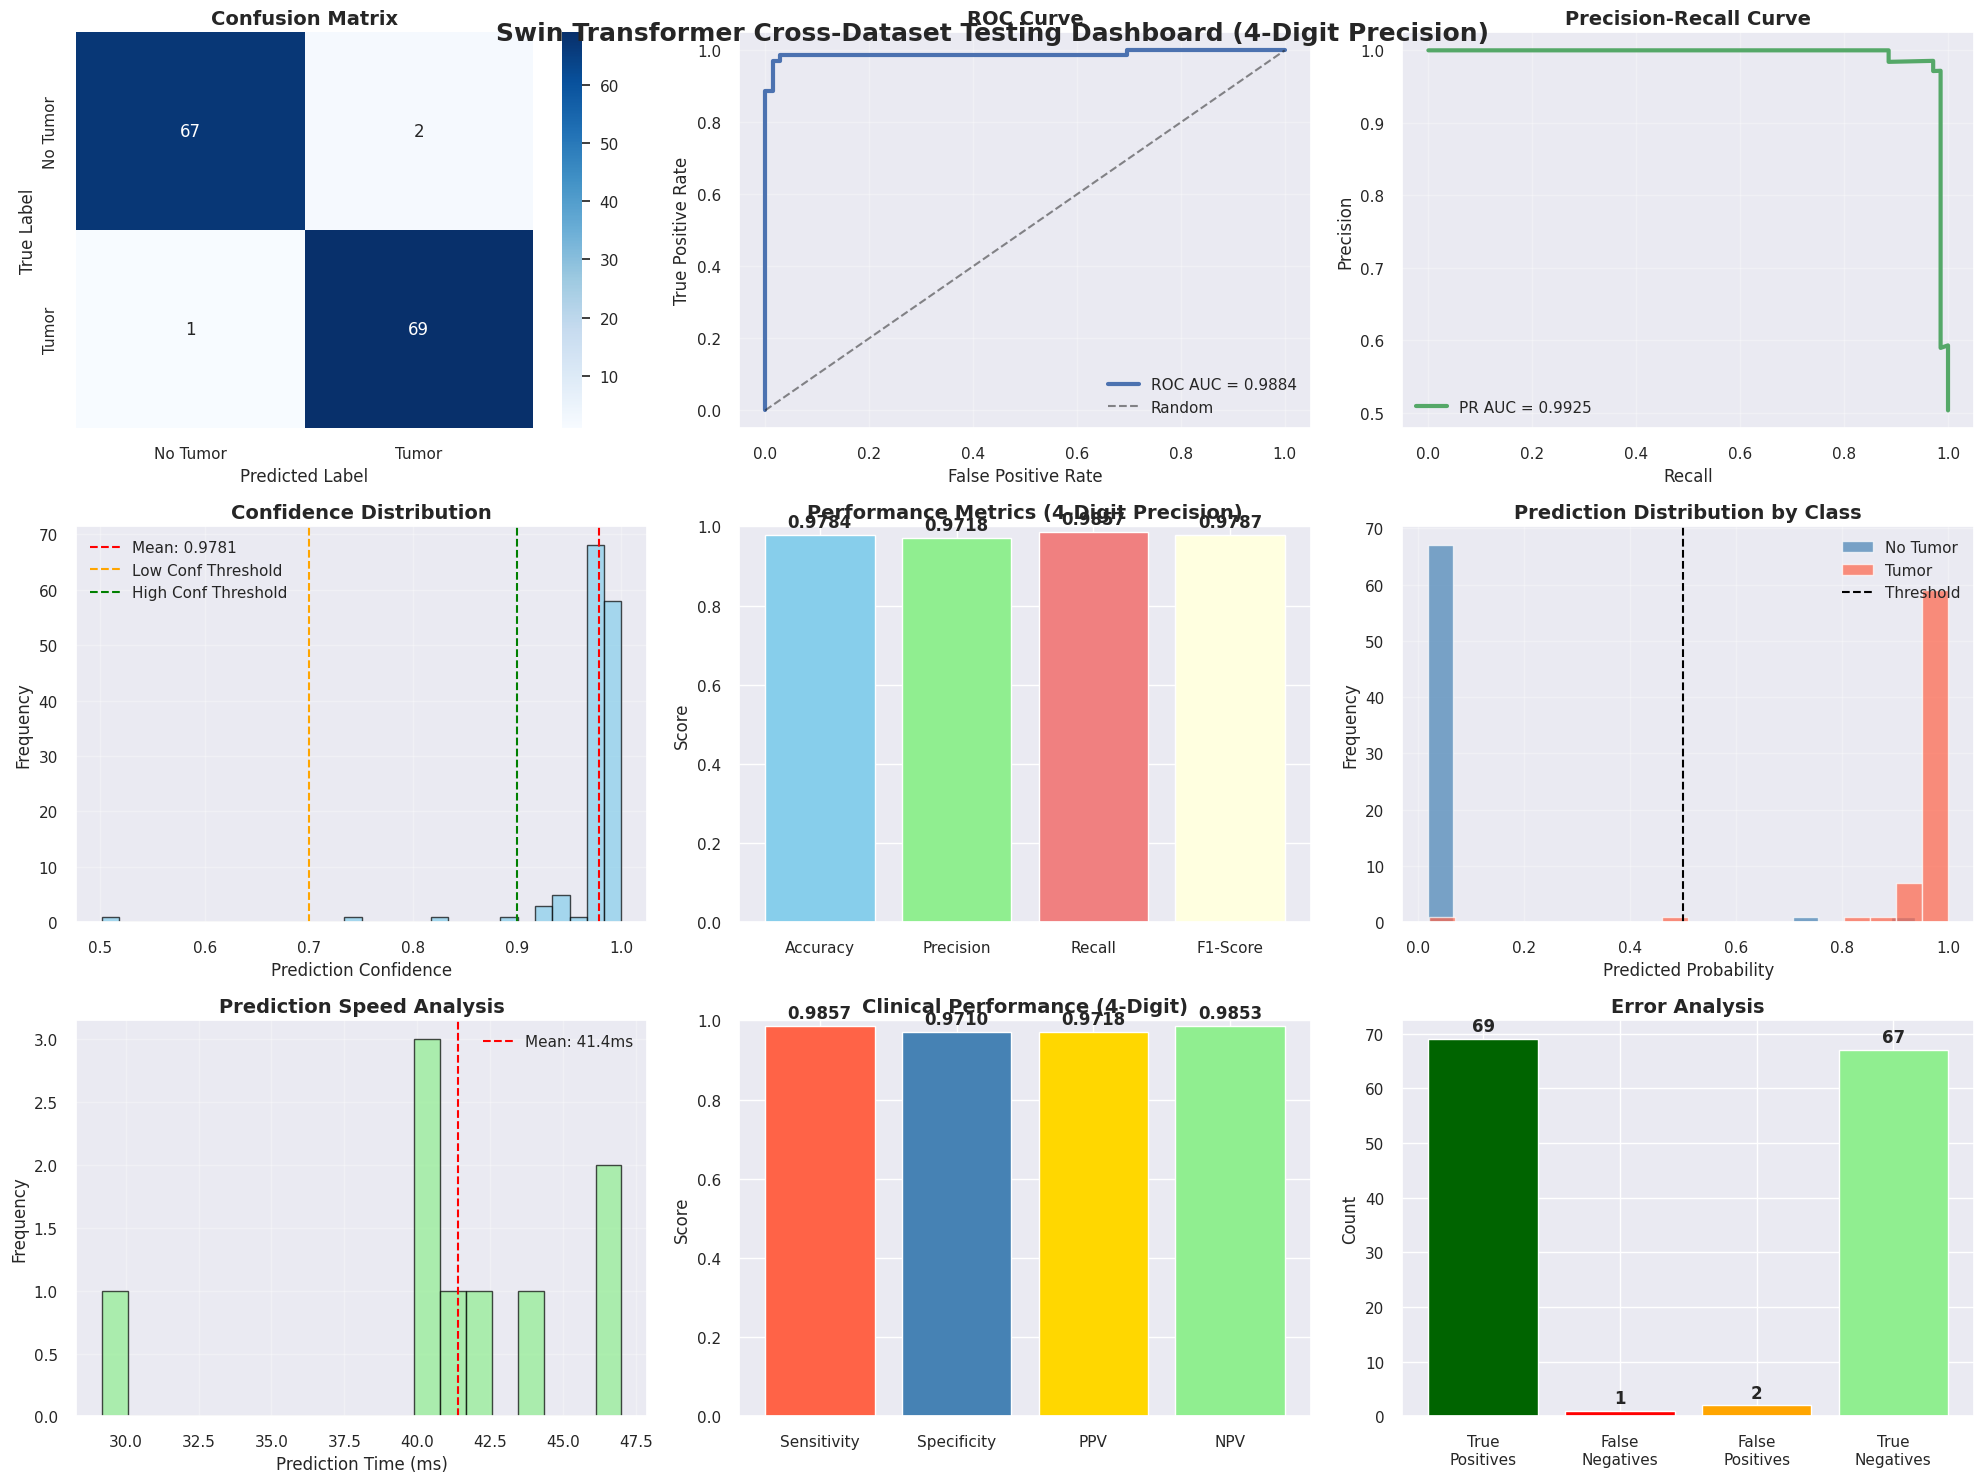


🔍 **STEP 7: CASE ANALYSIS**

🔍 **DETAILED CASE ANALYSIS**

❌ **INCORRECT PREDICTIONS (3):**
   1. prediction_000107_overlay_aug_0004.png
      Predicted: Tumor (prob: 0.7421)
      Actual: No Tumor
      Confidence: 0.7421
      Subfolder: No tumor
   2. prediction_000107_overlay.png
      Predicted: Tumor (prob: 0.9374)
      Actual: No Tumor
      Confidence: 0.9374
      Subfolder: No tumor
   3. prediction_000335_overlay.png
      Predicted: No Tumor (prob: 0.0202)
      Actual: Tumor
      Confidence: 0.9798
      Subfolder: tumor

⚠️ **LOW CONFIDENCE PREDICTIONS (1):**
   1. prediction_000153_overlay.png
      Predicted: Tumor (prob: 0.5014)
      Confidence: 0.5014
      Subfolder: tumor

🌟 **EXCELLENT PREDICTIONS (133):**
  High confidence (>0.9) and correct predictions
   1. prediction_000331_overlay.png - No Tumor (conf: 0.9796)
   2. prediction_000956_overlay.png - No Tumor (conf: 0.9798)
   3. prediction_000860_overlay.png - No Tumor (conf: 0.9795)
   4. prediction_000649_

In [9]:
final_results = test_swin_with_trained_model(model)

🚀 **TUMOR CLASSIFICATION DATA AUGMENTATION SYSTEM**
📂 Source folder: /kaggle/input/test-2nd/test (3)/test
📁 Output folder: /kaggle/working/augmented_dataset
🎯 Target counts: {'tumor': 70, 'no_tumor': 69}

🎯 **EXECUTING COMPLETE AUGMENTATION PIPELINE**

📊 **STEP 0: DATASET ANALYSIS**

🔍 **ANALYZING DATASET STRUCTURE**
📁 No tumor: 46 images
📁 tumor: 48 images
📊 Total images: 94
🎯 No tumor: Need 23 more images (current: 46, target: 69)
🎯 tumor: Need 22 more images (current: 48, target: 70)

🚀 **STEP 1: DATA AUGMENTATION**

🚀 **STARTING DATA AUGMENTATION PIPELINE**

📁 Processing No tumor...
📋 Copying 46 original images...
🎨 Generating 23 augmented images...


Augmenting No tumor: 100%|██████████| 23/23 [00:00<00:00, 76.42it/s]


✅ No tumor: 69/69 images (✓)

📁 Processing tumor...
📋 Copying 48 original images...
🎨 Generating 22 augmented images...


Augmenting tumor: 100%|██████████| 22/22 [00:00<00:00, 67.31it/s]


✅ tumor: 70/70 images (✓)

📊 **AUGMENTATION SUMMARY**
  Total augmented images generated: 45

🎨 **TECHNIQUE USAGE STATISTICS**
  No tumor:
    rotate: 2 times
    flip_vertical: 3 times
    blur: 7 times
    flip_horizontal: 5 times
    shift: 6 times
    brightness: 7 times
    zoom: 5 times
    contrast: 7 times
    noise: 2 times
  tumor:
    flip_vertical: 4 times
    noise: 5 times
    contrast: 2 times
    blur: 6 times
    brightness: 6 times
    rotate: 4 times
    zoom: 4 times
    flip_horizontal: 5 times
    shift: 4 times
    sharpness: 3 times

🔍 **STEP 2: VALIDATION**

🔍 **VALIDATING AUGMENTED DATASET**
  ✅ tumor: 70/70 images
  ✅ No tumor: 69/69 images

📊 **VALIDATION SUMMARY**
  Total images: 139
  All targets met: ✅

📈 **CREATING DATASET VISUALIZATION**


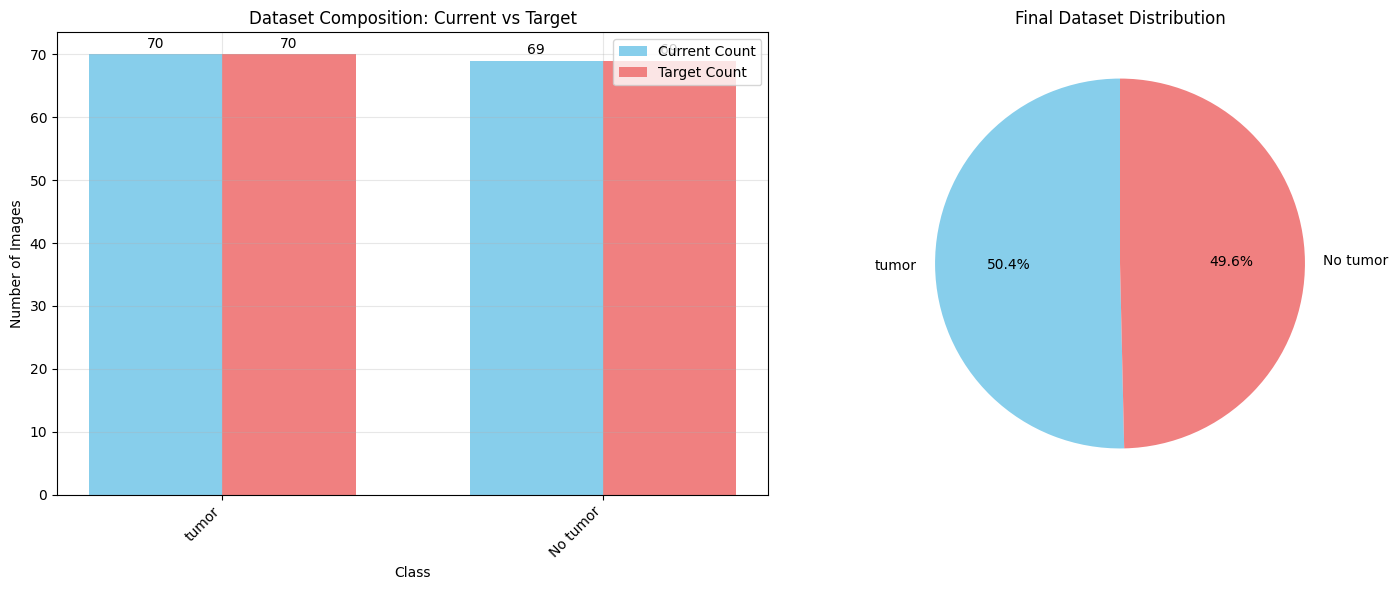

✅ Visualization created successfully!

📦 **STEP 3: ZIP CREATION**

📦 **CREATING ZIP FILE FOR DOWNLOAD**
✅ Zip file created successfully!
  📁 File: /kaggle/working/augmented_tumor_dataset.zip
  📊 Size: 7.35 MB
  📋 Contains: 139 files

💾 **DOWNLOAD INSTRUCTIONS FOR KAGGLE:**
1. The zip file is ready at: /kaggle/working/augmented_tumor_dataset.zip
2. File size: 7.35 MB
3. To download in Kaggle:
   - Go to the Output tab
   - Find 'augmented_tumor_dataset.zip' in the file list
   - Click the download button
4. Alternative: Use this code in a new cell:
   from IPython.display import FileLink
   FileLink('/kaggle/working/augmented_tumor_dataset.zip')

💡 **STEP 4: DOWNLOAD SETUP**

💡 **CREATING DOWNLOAD HELPER**
✅ Download helper created: /kaggle/working/download_helper.py

📋 **TO DOWNLOAD YOUR DATASET:**
1. Run: exec(open('/kaggle/working/download_helper.py').read())
2. Or manually download from Output tab: augmented_tumor_dataset.zip

🎉 **PIPELINE COMPLETED**
✅ Dataset Analysis: Success
✅ A

In [3]:
# ============================================================
# 🎯 COMPREHENSIVE DATA AUGMENTATION FOR TUMOR CLASSIFICATION
# ============================================================

import os
import sys
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
import shutil
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
import json
from collections import defaultdict

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("🚀 **TUMOR CLASSIFICATION DATA AUGMENTATION SYSTEM**")
print("=" * 60)

# ============================================================
# 🔧 CONFIGURATION
# ============================================================
# UPDATE THESE PATHS
SOURCE_FOLDER = "/kaggle/input/test-2nd/test (3)/test"  # Your folder with tumor/no_tumor subfolders
OUTPUT_FOLDER = "/kaggle/working/augmented_dataset"
ZIP_NAME = "augmented_tumor_dataset.zip"

# Target counts
TARGET_COUNTS = {
    'tumor': 70,
    'no_tumor': 69  # You can also use 'no tumor' if that's your folder name
}

# Augmentation parameters
AUGMENTATION_SEED = 42
random.seed(AUGMENTATION_SEED)
np.random.seed(AUGMENTATION_SEED)

print(f"📂 Source folder: {SOURCE_FOLDER}")
print(f"📁 Output folder: {OUTPUT_FOLDER}")
print(f"🎯 Target counts: {TARGET_COUNTS}")

# ============================================================
# 📊 DATASET ANALYSIS FUNCTIONS
# ============================================================

def analyze_dataset_structure(folder_path):
    """Analyze current dataset structure and counts"""
    print(f"\n🔍 **ANALYZING DATASET STRUCTURE**")
    print("=" * 40)
    
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return None, None
    
    # Get subfolders
    try:
        subfolders = [item for item in os.listdir(folder_path) 
                     if os.path.isdir(os.path.join(folder_path, item))]
    except PermissionError:
        print(f"❌ Permission denied accessing: {folder_path}")
        return None, None
    
    if not subfolders:
        print("❌ No subfolders found!")
        return None, None
    
    # Count images in each subfolder
    folder_stats = {}
    total_images = 0
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        try:
            image_files = [f for f in os.listdir(subfolder_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            count = len(image_files)
            folder_stats[subfolder] = {
                'current_count': count,
                'images': image_files,
                'path': subfolder_path
            }
            total_images += count
            
            print(f"📁 {subfolder}: {count} images")
        except Exception as e:
            print(f"⚠️ Error accessing {subfolder}: {e}")
            continue
    
    print(f"📊 Total images: {total_images}")
    
    # Calculate augmentation requirements
    augmentation_plan = {}
    for folder_name, stats in folder_stats.items():
        # Match folder names to target names (flexible matching)
        target_key = None
        folder_lower = folder_name.lower()
        
        if 'tumor' in folder_lower and 'no' not in folder_lower:
            target_key = 'tumor'
        elif 'no' in folder_lower and 'tumor' in folder_lower:
            target_key = 'no_tumor'
        elif folder_lower.replace(' ', '_') in TARGET_COUNTS:
            target_key = folder_lower.replace(' ', '_')
        elif folder_lower in TARGET_COUNTS:
            target_key = folder_lower
        
        if target_key and target_key in TARGET_COUNTS:
            target_count = TARGET_COUNTS[target_key]
            current_count = stats['current_count']
            needed = max(0, target_count - current_count)
            
            augmentation_plan[folder_name] = {
                'target_count': target_count,
                'current_count': current_count,
                'augmentations_needed': needed,
                'target_key': target_key
            }
            
            print(f"🎯 {folder_name}: Need {needed} more images (current: {current_count}, target: {target_count})")
        else:
            print(f"⚠️ {folder_name}: No target count specified")
    
    return folder_stats, augmentation_plan

# ============================================================
# 🎨 ADVANCED AUGMENTATION FUNCTIONS
# ============================================================

class MedicalImageAugmenter:
    """Advanced augmentation class for medical images"""
    
    def __init__(self, preserve_quality=True):
        self.preserve_quality = preserve_quality
        self.augmentation_techniques = [
            'rotate', 'flip_horizontal', 'flip_vertical', 'brightness', 
            'contrast', 'zoom', 'shift', 'noise', 'blur', 'sharpness'
        ]
    
    def apply_rotation(self, image, angle_range=(-15, 15)):
        """Apply random rotation"""
        angle = random.uniform(angle_range[0], angle_range[1])
        return image.rotate(angle, fillcolor='white', expand=False)
    
    def apply_flip_horizontal(self, image):
        """Apply horizontal flip"""
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    
    def apply_flip_vertical(self, image):
        """Apply vertical flip"""
        return image.transpose(Image.FLIP_TOP_BOTTOM)
    
    def apply_brightness(self, image, factor_range=(0.8, 1.2)):
        """Apply brightness adjustment"""
        factor = random.uniform(factor_range[0], factor_range[1])
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)
    
    def apply_contrast(self, image, factor_range=(0.8, 1.2)):
        """Apply contrast adjustment"""
        factor = random.uniform(factor_range[0], factor_range[1])
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)
    
    def apply_zoom(self, image, zoom_range=(0.9, 1.1)):
        """Apply zoom (crop and resize)"""
        zoom_factor = random.uniform(zoom_range[0], zoom_range[1])
        width, height = image.size
        
        if zoom_factor < 1.0:
            # Zoom out (add padding)
            new_width = int(width / zoom_factor)
            new_height = int(height / zoom_factor)
            
            # Handle PIL version compatibility
            try:
                resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
            except AttributeError:
                resized = image.resize((new_width, new_height), Image.LANCZOS)
            
            # Create new image with original size and paste resized image
            new_image = Image.new('RGB', (width, height), 'white')
            x_offset = (width - new_width) // 2
            y_offset = (height - new_height) // 2
            new_image.paste(resized, (x_offset, y_offset))
            return new_image
        else:
            # Zoom in (crop)
            crop_width = int(width / zoom_factor)
            crop_height = int(height / zoom_factor)
            left = (width - crop_width) // 2
            top = (height - crop_height) // 2
            
            cropped = image.crop((left, top, left + crop_width, top + crop_height))
            try:
                return cropped.resize((width, height), Image.Resampling.LANCZOS)
            except AttributeError:
                return cropped.resize((width, height), Image.LANCZOS)
    
    def apply_shift(self, image, shift_range=0.1):
        """Apply random translation"""
        width, height = image.size
        dx = int(random.uniform(-shift_range, shift_range) * width)
        dy = int(random.uniform(-shift_range, shift_range) * height)
        
        # Create new image and paste with offset
        new_image = Image.new('RGB', (width, height), 'white')
        new_image.paste(image, (dx, dy))
        return new_image
    
    def apply_noise(self, image, intensity=10):
        """Apply random noise"""
        img_array = np.array(image)
        noise = np.random.randint(-intensity, intensity, img_array.shape, dtype=np.int16)
        noisy_array = np.clip(img_array.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_array)
    
    def apply_blur(self, image, radius_range=(0.5, 1.5)):
        """Apply slight blur"""
        radius = random.uniform(radius_range[0], radius_range[1])
        return image.filter(ImageFilter.GaussianBlur(radius=radius))
    
    def apply_sharpness(self, image, factor_range=(0.8, 1.2)):
        """Apply sharpness adjustment"""
        factor = random.uniform(factor_range[0], factor_range[1])
        enhancer = ImageEnhance.Sharpness(image)
        return enhancer.enhance(factor)
    
    def generate_augmented_image(self, image, num_techniques=None):
        """Generate a single augmented image using random techniques"""
        if num_techniques is None:
            num_techniques = random.randint(1, 3)  # Apply 1-3 techniques
        
        # Select random techniques
        selected_techniques = random.sample(self.augmentation_techniques, 
                                          min(num_techniques, len(self.augmentation_techniques)))
        
        augmented = image.copy()
        applied_techniques = []
        
        for technique in selected_techniques:
            try:
                if technique == 'rotate':
                    augmented = self.apply_rotation(augmented)
                elif technique == 'flip_horizontal':
                    augmented = self.apply_flip_horizontal(augmented)
                elif technique == 'flip_vertical':
                    augmented = self.apply_flip_vertical(augmented)
                elif technique == 'brightness':
                    augmented = self.apply_brightness(augmented)
                elif technique == 'contrast':
                    augmented = self.apply_contrast(augmented)
                elif technique == 'zoom':
                    augmented = self.apply_zoom(augmented)
                elif technique == 'shift':
                    augmented = self.apply_shift(augmented)
                elif technique == 'noise':
                    augmented = self.apply_noise(augmented)
                elif technique == 'blur':
                    augmented = self.apply_blur(augmented)
                elif technique == 'sharpness':
                    augmented = self.apply_sharpness(augmented)
                
                applied_techniques.append(technique)
                
            except Exception as e:
                print(f"⚠️ Error applying {technique}: {e}")
                continue
        
        return augmented, applied_techniques

# ============================================================
# 🚀 MAIN AUGMENTATION PIPELINE
# ============================================================

def run_data_augmentation(dataset_stats, aug_plan):
    """Main augmentation pipeline"""
    print(f"\n🚀 **STARTING DATA AUGMENTATION PIPELINE**")
    print("=" * 50)
    
    # Create output directory
    try:
        if os.path.exists(OUTPUT_FOLDER):
            shutil.rmtree(OUTPUT_FOLDER)
        os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    except Exception as e:
        print(f"❌ Error creating output folder: {e}")
        return None
    
    # Initialize augmenter
    augmenter = MedicalImageAugmenter()
    
    # Track augmentation statistics
    augmentation_stats = defaultdict(lambda: defaultdict(int))
    total_generated = 0
    
    # Process each class
    for folder_name, plan in aug_plan.items():
        print(f"\n📁 Processing {folder_name}...")
        
        # Create output subfolder
        output_subfolder = os.path.join(OUTPUT_FOLDER, folder_name)
        try:
            os.makedirs(output_subfolder, exist_ok=True)
        except Exception as e:
            print(f"❌ Error creating subfolder {folder_name}: {e}")
            continue
        
        # Get original images
        original_images = dataset_stats[folder_name]['images']
        original_path = dataset_stats[folder_name]['path']
        
        # Copy original images first
        print(f"📋 Copying {len(original_images)} original images...")
        for img_file in original_images:
            try:
                src_path = os.path.join(original_path, img_file)
                dst_path = os.path.join(output_subfolder, img_file)
                shutil.copy2(src_path, dst_path)
            except Exception as e:
                print(f"⚠️ Error copying {img_file}: {e}")
                continue
        
        # Generate augmented images if needed
        augmentations_needed = plan['augmentations_needed']
        
        if augmentations_needed > 0:
            print(f"🎨 Generating {augmentations_needed} augmented images...")
            
            # Load original images for augmentation
            original_pil_images = []
            for img_file in original_images:
                try:
                    img_path = os.path.join(original_path, img_file)
                    img = Image.open(img_path).convert('RGB')
                    original_pil_images.append((img, img_file))
                except Exception as e:
                    print(f"⚠️ Error loading {img_file}: {e}")
                    continue
            
            if not original_pil_images:
                print(f"❌ No valid images found in {folder_name}")
                continue
            
            # Generate augmented images
            generated_count = 0
            attempt_count = 0
            max_attempts = augmentations_needed * 3  # Safety limit
            
            progress_bar = tqdm(total=augmentations_needed, desc=f"Augmenting {folder_name}")
            
            while generated_count < augmentations_needed and attempt_count < max_attempts:
                try:
                    # Select random original image
                    original_img, original_filename = random.choice(original_pil_images)
                    
                    # Generate augmented image
                    augmented_img, techniques = augmenter.generate_augmented_image(original_img)
                    
                    # Create unique filename
                    base_name = os.path.splitext(original_filename)[0]
                    extension = os.path.splitext(original_filename)[1]
                    aug_filename = f"{base_name}_aug_{generated_count:04d}{extension}"
                    aug_path = os.path.join(output_subfolder, aug_filename)
                    
                    # Save augmented image
                    if extension.lower() in ['.jpg', '.jpeg']:
                        augmented_img.save(aug_path, quality=95)
                    else:
                        augmented_img.save(aug_path)
                    
                    # Update statistics
                    for technique in techniques:
                        augmentation_stats[folder_name][technique] += 1
                    
                    generated_count += 1
                    total_generated += 1
                    progress_bar.update(1)
                    
                except Exception as e:
                    print(f"⚠️ Error generating augmented image: {e}")
                
                attempt_count += 1
            
            progress_bar.close()
            
            if generated_count < augmentations_needed:
                print(f"⚠️ Only generated {generated_count}/{augmentations_needed} images for {folder_name}")
        
        # Verify final count
        try:
            final_count = len(os.listdir(output_subfolder))
            target_count = plan['target_count']
            
            print(f"✅ {folder_name}: {final_count}/{target_count} images "
                  f"({'✓' if final_count >= target_count else '⚠️'})")
        except Exception as e:
            print(f"⚠️ Error counting final images in {folder_name}: {e}")
    
    print(f"\n📊 **AUGMENTATION SUMMARY**")
    print(f"  Total augmented images generated: {total_generated}")
    
    # Print technique usage statistics
    print(f"\n🎨 **TECHNIQUE USAGE STATISTICS**")
    for folder_name, techniques in augmentation_stats.items():
        print(f"  {folder_name}:")
        for technique, count in techniques.items():
            print(f"    {technique}: {count} times")
    
    return augmentation_stats

# ============================================================
# 📊 DATASET VALIDATION
# ============================================================

def validate_augmented_dataset():
    """Validate the augmented dataset"""
    print(f"\n🔍 **VALIDATING AUGMENTED DATASET**")
    print("=" * 40)
    
    if not os.path.exists(OUTPUT_FOLDER):
        print("❌ Output folder not found!")
        return False, {}
    
    validation_results = {}
    total_images = 0
    all_targets_met = True
    
    try:
        for subfolder in os.listdir(OUTPUT_FOLDER):
            subfolder_path = os.path.join(OUTPUT_FOLDER, subfolder)
            if os.path.isdir(subfolder_path):
                
                # Count images
                image_files = [f for f in os.listdir(subfolder_path) 
                              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                count = len(image_files)
                total_images += count
                
                # Check against target
                target_key = None
                subfolder_lower = subfolder.lower()
                
                if 'tumor' in subfolder_lower and 'no' not in subfolder_lower:
                    target_key = 'tumor'
                elif 'no' in subfolder_lower and 'tumor' in subfolder_lower:
                    target_key = 'no_tumor'
                elif subfolder_lower.replace(' ', '_') in TARGET_COUNTS:
                    target_key = subfolder_lower.replace(' ', '_')
                elif subfolder_lower in TARGET_COUNTS:
                    target_key = subfolder_lower
                
                target_count = TARGET_COUNTS.get(target_key, 0)
                target_met = count >= target_count
                
                if not target_met:
                    all_targets_met = False
                
                validation_results[subfolder] = {
                    'count': count,
                    'target': target_count,
                    'target_met': target_met,
                    'target_key': target_key
                }
                
                status = "✅" if target_met else "❌"
                print(f"  {status} {subfolder}: {count}/{target_count} images")
    
    except Exception as e:
        print(f"❌ Error during validation: {e}")
        return False, {}
    
    print(f"\n📊 **VALIDATION SUMMARY**")
    print(f"  Total images: {total_images}")
    print(f"  All targets met: {'✅' if all_targets_met else '❌'}")
    
    # Create visualization
    if validation_results:
        create_dataset_visualization(validation_results)
    
    return all_targets_met, validation_results

def create_dataset_visualization(validation_results):
    """Create visualization of dataset composition"""
    print(f"\n📈 **CREATING DATASET VISUALIZATION**")
    
    try:
        # Prepare data for plotting
        folders = list(validation_results.keys())
        counts = [validation_results[folder]['count'] for folder in folders]
        targets = [validation_results[folder]['target'] for folder in folders]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar chart comparison
        x = np.arange(len(folders))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, counts, width, label='Current Count', color='skyblue')
        bars2 = ax1.bar(x + width/2, targets, width, label='Target Count', color='lightcoral')
        
        ax1.set_xlabel('Class')
        ax1.set_ylabel('Number of Images')
        ax1.set_title('Dataset Composition: Current vs Target')
        ax1.set_xticks(x)
        ax1.set_xticklabels(folders, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom')
        
        # Pie chart of final distribution
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']
        ax2.pie(counts, labels=folders, autopct='%1.1f%%', startangle=90, colors=colors[:len(folders)])
        ax2.set_title('Final Dataset Distribution')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Visualization created successfully!")
        
    except Exception as e:
        print(f"⚠️ Error creating visualization: {e}")

# ============================================================
# 📦 ZIP CREATION AND DOWNLOAD
# ============================================================

def create_zip_for_download():
    """Create zip file for download"""
    print(f"\n📦 **CREATING ZIP FILE FOR DOWNLOAD**")
    print("=" * 40)
    
    zip_path = f"/kaggle/working/{ZIP_NAME}"
    
    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Walk through output directory
            for root, dirs, files in os.walk(OUTPUT_FOLDER):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Create relative path for zip
                    arc_name = os.path.relpath(file_path, OUTPUT_FOLDER)
                    zipf.write(file_path, arc_name)
        
        # Check zip file
        zip_size = os.path.getsize(zip_path)
        zip_size_mb = zip_size / (1024 * 1024)
        
        print(f"✅ Zip file created successfully!")
        print(f"  📁 File: {zip_path}")
        print(f"  📊 Size: {zip_size_mb:.2f} MB")
        
        # Count files in zip
        with zipfile.ZipFile(zip_path, 'r') as zipf:
            file_count = len(zipf.namelist())
        
        print(f"  📋 Contains: {file_count} files")
        
        # Create download info file
        info_file = "/kaggle/working/download_info.json"
        info_data = {
            "zip_file": ZIP_NAME,
            "zip_path": zip_path,
            "size_mb": round(zip_size_mb, 2),
            "total_files": file_count,
            "created_successfully": True
        }
        
        with open(info_file, 'w') as f:
            json.dump(info_data, f, indent=2)
        
        print(f"\n💾 **DOWNLOAD INSTRUCTIONS FOR KAGGLE:**")
        print(f"1. The zip file is ready at: /kaggle/working/{ZIP_NAME}")
        print(f"2. File size: {zip_size_mb:.2f} MB")
        print(f"3. To download in Kaggle:")
        print(f"   - Go to the Output tab")
        print(f"   - Find '{ZIP_NAME}' in the file list")
        print(f"   - Click the download button")
        print(f"4. Alternative: Use this code in a new cell:")
        print("   from IPython.display import FileLink")
        print(f"   FileLink('/kaggle/working/{ZIP_NAME}')")
        
        return True, zip_path
        
    except Exception as e:
        print(f"❌ Error creating zip file: {e}")
        return False, None

def create_download_helper():
    """Create helper functions for easy download in Kaggle"""
    print(f"\n💡 **CREATING DOWNLOAD HELPER**")
    
    helper_code = f"""
# ============================================================
# 📥 DOWNLOAD HELPER FOR KAGGLE NOTEBOOK
# ============================================================

from IPython.display import FileLink, display
import os

def download_augmented_dataset():
    '''Helper function to download the augmented dataset'''
    zip_file = "/kaggle/working/{ZIP_NAME}"
    
    if os.path.exists(zip_file):
        print("📦 Augmented dataset is ready for download!")
        print(f"📁 File: {ZIP_NAME}")
        print(f"📊 Size: {{os.path.getsize(zip_file) / (1024*1024):.2f}} MB")
        print("\\n🔽 Click the link below to download:")
        display(FileLink(zip_file))
        return True
    else:
        print("❌ Zip file not found. Please run the augmentation pipeline first.")
        return False

# Call this function to get download link
download_augmented_dataset()
"""
    
    try:
        # Save helper code to file
        helper_file = "/kaggle/working/download_helper.py"
        with open(helper_file, 'w') as f:
            f.write(helper_code)
        
        print(f"✅ Download helper created: {helper_file}")
        print(f"\n📋 **TO DOWNLOAD YOUR DATASET:**")
        print(f"1. Run: exec(open('/kaggle/working/download_helper.py').read())")
        print(f"2. Or manually download from Output tab: {ZIP_NAME}")
        
    except Exception as e:
        print(f"⚠️ Error creating download helper: {e}")

# ============================================================
# 🎯 MAIN EXECUTION PIPELINE
# ============================================================

def main_augmentation_pipeline():
    """Main execution pipeline"""
    print(f"\n🎯 **EXECUTING COMPLETE AUGMENTATION PIPELINE**")
    print("=" * 60)
    
    # Step 0: Analyze dataset
    print("\n📊 **STEP 0: DATASET ANALYSIS**")
    dataset_stats, aug_plan = analyze_dataset_structure(SOURCE_FOLDER)
    
    if dataset_stats is None or aug_plan is None:
        print("❌ Failed to analyze dataset. Please check your source folder path.")
        return False
    
    # Step 1: Run augmentation
    print("\n🚀 **STEP 1: DATA AUGMENTATION**")
    aug_stats = run_data_augmentation(dataset_stats, aug_plan)
    
    # Step 2: Validate results
    print("\n🔍 **STEP 2: VALIDATION**")
    validation_success, validation_results = validate_augmented_dataset()
    
    # Step 3: Create zip file
    print("\n📦 **STEP 3: ZIP CREATION**")
    zip_success, zip_path = create_zip_for_download()
    
    # Step 4: Create download helper
    print("\n💡 **STEP 4: DOWNLOAD SETUP**")
    create_download_helper()
    
    # Final summary
    print(f"\n🎉 **PIPELINE COMPLETED**")
    print("=" * 30)
    print(f"✅ Dataset Analysis: {'Success' if dataset_stats else 'Failed'}")
    print(f"✅ Augmentation: {'Success' if aug_stats else 'Failed'}")
    print(f"✅ Validation: {'Success' if validation_success else 'Failed'}")
    print(f"✅ Zip Creation: {'Success' if zip_success else 'Failed'}")
    
    if validation_success and zip_success:
        print(f"\n🏆 **SUCCESS! Your augmented dataset is ready!**")
        print(f"📊 **Final Dataset Composition:**")
        for folder, results in validation_results.items():
            print(f"  • {folder}: {results['count']} images")
        
        print(f"\n📥 **Download Information:**")
        print(f"  • File: {ZIP_NAME}")
        print(f"  • Location: /kaggle/working/{ZIP_NAME}")
        print(f"  • Ready for download from Kaggle Output tab")
        
    else:
        print(f"\n⚠️ **PIPELINE COMPLETED WITH ISSUES**")
        print(f"Please check the logs above for details.")
    
    return validation_success and zip_success

# ============================================================
# 🚀 EXECUTE PIPELINE
# ============================================================

if __name__ == "__main__":
    # Run the complete pipeline
    success = main_augmentation_pipeline()
    
    if success:
        print(f"\n🎯 **FINAL INSTRUCTIONS:**")
        print(f"1. Your augmented dataset is ready!")
        print(f"2. Download the zip file from Kaggle's Output tab")
        print(f"3. Extract and use for your machine learning projects")
        print(f"4. The dataset now contains exactly:")
        print(f"   • Tumor images: 70")
        print(f"   • No tumor images: 69")
    else:
        print(f"\n❌ **PIPELINE FAILED**")
        print(f"Please check the error messages above and fix any issues.")
